# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [13]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = 'updated_data' # You many change the directory

# Other main package imports
import seaborn as sns
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection
from sklearn.metrics import root_mean_squared_error, mean_squared_error, roc_auc_score

# PyBKT package imports
import random
old_randint = random.randint
random.randint = lambda a, b: old_randint(a, int(b))
from pyBKT.models import Model
random.randint = old_randint

## Task 0: Research Question

**Research question:**
Does AI usage increase student performance?

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [14]:
# 1. Map Gymitrainer data to rest of tables 
gymitrainer_df = pd.read_csv(f"{DATA_DIR}/gymitrainer.csv")
gymitrainer_df = gymitrainer_df.drop(columns=['chat_profile'])
#display(gymitrainer_df.head())
mapping_df = pd.read_csv(f"{DATA_DIR}/mapping.csv")
#display(mapping_df.head())

threshold = 0.5
filtered_mapping = mapping_df[mapping_df['confidence'] >= threshold]

# Contains only users where the matching is confident enough and who 
# used the chatbot at all (since they appear in gymitrainer.csv)
# Inner merging guarantees that we only have people who used the chatbot
matched_gymitrainer = pd.merge(
    gymitrainer_df,
    filtered_mapping[['id', 'user_id']],
    on='id',
    how='inner'  
)

In [15]:
tag_replacements = {
    'Mathehilfe': 'Mathe',
    'math_help': 'Mathe',
    'essay_writing': 'Aufsatz',
    'Aufsatzhilfe': 'Aufsatz',
    'Sprachprufung': 'Sprache',
    'text_comprehension': 'Sprache'
}

matched_gymitrainer['tag'] = matched_gymitrainer['tag'].replace(tag_replacements)

def fill_missing_tag(row):
    if pd.isna(row['tag']) or row['tag'] == '':
        content = str(row['content'])
        if content.startswith("['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor") or \
           content.startswith("['Hallo! Mein Name ist Gymitrainer, und ich bin dein Mathe-Guru"):
            return 'Mathe'
        elif content.startswith("['Hey! Ich bin Gymitrainer, dein Experte für Gymi-Prüfungsaufsätze"):
            return 'Aufsatz'
        else:
            return row['tag']
    else:
        return row['tag']

matched_gymitrainer['tag'] = matched_gymitrainer.apply(fill_missing_tag, axis=1)

matched_gymitrainer = matched_gymitrainer.sort_values(by='user_id')
display(matched_gymitrainer.head())   

,Unnamed: 0,id,tag,message_count,startTime,endTime,content,user_id
1630,4454,321dae4e-6d92-40be-b780-232cecf3b586,NaN,1,1730219336,1730219336,['wie soll ich das rechnen'],4
1629,4453,74677c94-340b-4017-9cba-5d38cd1bf581,Aufsatz,3,1730219315,1730220391,"[""Hey! Ich bin Gymitrainer, dein Experte für G...",4
305,772,109cbf59-7ca4-49d7-9879-40d79e666557,Aufsatz,2,1738769310,1738769622,"[""Hey! Ich bin Gymitrainer, dein Experte für G...",6
313,803,bf6c477d-578b-4234-9126-636c64fc09a4,Mathe,3,1738678028,1738681716,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",6
526,1443,6923b14e-55b3-4aee-8d9c-fd5305295cb2,Mathe,1,1736181505,1736184444,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",6


In [16]:
# 2. Remove potential teachers from the dataset as a safety 
# (we only want to study learning on students)
teachers = pd.read_csv(f"{DATA_DIR}/teachers.csv")
teacher_ids = teachers['user_id'].unique()
matched_gymitrainer = matched_gymitrainer[~matched_gymitrainer['user_id'].isin(teacher_ids)].copy()

In [17]:
# 3. Clean and prepare the datasets by subjects 
math_results = pd.read_csv(f"{DATA_DIR}/math_results.csv")
math_questions_clean = pd.read_csv(f"{DATA_DIR}/math_questions_clean.csv")
math_results['question'] = math_results['question'].astype(str)
math_questions_clean['question_id'] = math_questions_clean['question_id'].astype(str)
math_results_clean = math_results[
    math_results['question'].isin(math_questions_clean['question_id'])
] 
math_results_clean = math_results_clean.merge(
    math_questions_clean[['question_id', 'skill_id']],
    left_on='question',
    right_on='question_id',
    how='left'
)
math_results_clean = math_results_clean.drop(columns=['question_id'])
math_results_clean['timestamp'] = math_results_clean['time'].astype(int)
math_results_clean['correct'] = math_results_clean['correct'].astype(int)
math_results_clean['hint_used'] = (math_results_clean['hint_count'] > 0).astype(int)

math_data = math_results_clean[['user_id', 'skill_id', 'correct', 'timestamp', 'hint_used']]

In [18]:
# 4. Define AI usage for each user, by subject (a heavy AI user in Essays might not be a heavy AI 
# user in Math, and the criteria shall not be the same as users send many more messages on average
# to Gymitrainer for Math than for other subjects)
subject_tags = ['Mathe', 'Aufsatz', 'Sprache']

ai_usage_per_subject = matched_gymitrainer[matched_gymitrainer['tag'].isin(subject_tags)].groupby(['user_id', 'tag']).size().unstack(fill_value=0)

for subject in subject_tags:
    if subject not in ai_usage_per_subject.columns:
        ai_usage_per_subject[subject] = 0

print("# of Messages for each User, by Subject", ai_usage_per_subject.head())

def compute_threshold(series, percentile=75):
    non_zero = series[series > 0]
    return np.percentile(non_zero, percentile) if len(non_zero) > 0 else 0

def categorize_usage(count, threshold):
    if count == 0:
        return 'non_ai_user'
    elif count <= threshold:
        return 'light_ai_user'
    else:
        return 'heavy_ai_user'

cutoff_percentile = 75

for subject in subject_tags:
    threshold = compute_threshold(ai_usage_per_subject[subject], percentile=cutoff_percentile)
    ai_usage_per_subject[f'{subject}_ai_usage_category'] = ai_usage_per_subject[subject].apply(
        lambda x: categorize_usage(x, threshold)
    )

print("# of Messages for each User, by Subject", ai_usage_per_subject[[f'{s}_ai_usage_category' for s in subject_tags]].head())

# of Messages for each User, by Subject tag      Aufsatz  Mathe  Sprache
user_id                         
4              1      0        0
6              2      7        0
7              0      2        0
9              0      4        0
11             0      3        0
# of Messages for each User, by Subject tag     Mathe_ai_usage_category Aufsatz_ai_usage_category  \
user_id                                                     
4                   non_ai_user             light_ai_user   
6                 heavy_ai_user             light_ai_user   
7                 light_ai_user               non_ai_user   
9                 light_ai_user               non_ai_user   
11                light_ai_user               non_ai_user   

tag     Sprache_ai_usage_category  
user_id                            
4                     non_ai_user  
6                     non_ai_user  
7                     non_ai_user  
9                     non_ai_user  
11                    non_ai_user  


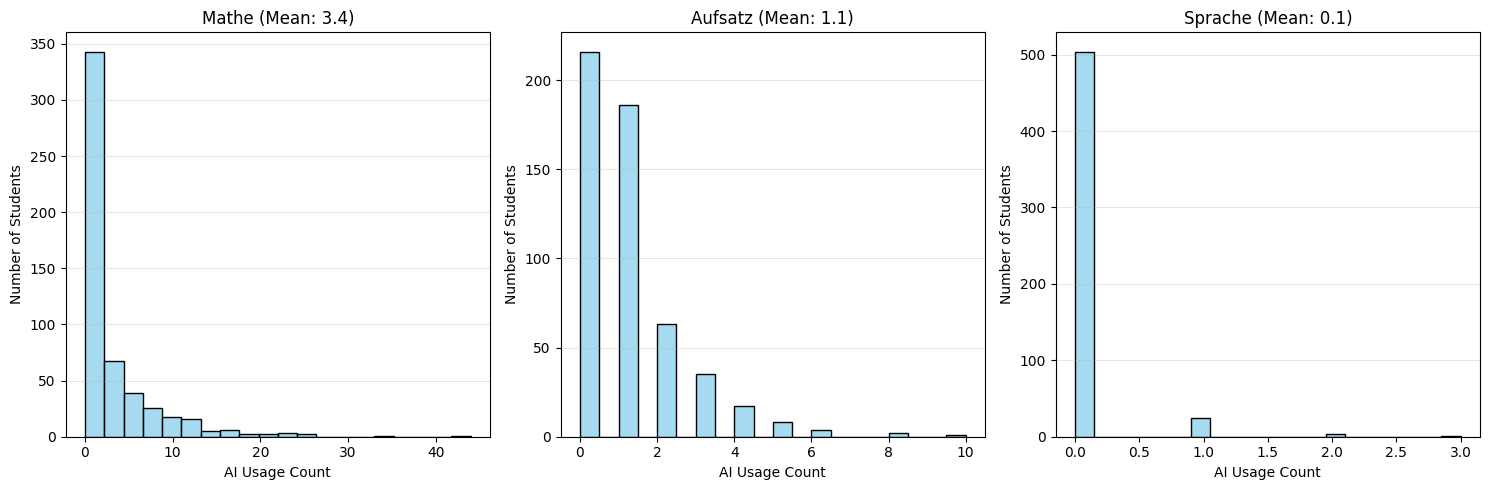

In [19]:
plt.figure(figsize=(15, 5))
for i, subject in enumerate(subject_tags, 1):
    toplot = ai_usage_per_subject[subject]
    if(subject == "Mathe"):
        toplot = ai_usage_per_subject[subject].nsmallest(len(ai_usage_per_subject[subject]) -1 ) #disregard outlier in math
    plt.subplot(1, 3, i)
    sns.histplot(toplot, bins=20, kde=False, color='skyblue')
    plt.title(f'{subject} (Mean: {ai_usage_per_subject[subject].mean():.1f})')
    plt.xlabel('AI Usage Count')
    plt.ylabel('Number of Students')
    plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# 5. Create dataframes that contain info on a user's AI usage
math_data_with_ai = math_data.merge(
    ai_usage_per_subject[['Mathe', 'Mathe_ai_usage_category']], 
    on='user_id', 
    how='left'
)

math_data_with_ai['Mathe'] = math_data_with_ai['Mathe'].fillna(0)
math_data_with_ai['Mathe_ai_usage_category'] = math_data_with_ai['Mathe_ai_usage_category'].fillna('non_ai_user')

math_data_categorical = math_data_with_ai.sort_values(
    by=['user_id', 'timestamp'],
    ascending=[True, True]
).reset_index(drop=True)

In [21]:
# 6. Add order_id column that orders a user-id's submissions by skill and time
math_data_categorical['order_id'] = math_data_categorical.groupby('user_id').cumcount() + 1

# 7. Extra columns added to use for AFM/PFA
def preprocess_data(data):
    data = data.copy()  # Avoid modifying a slice of the original DataFrame
    data.loc[:, 'aux'] = 1
    data.loc[:, 'prev_attempts'] = data.sort_values('order_id').groupby(['user_id', 'skill_id'])['aux'].cumsum() - 1

    # Number of correct and incorrect attempts before current attempt
    data.loc[:, 'correct_aux'] = data.sort_values('order_id').groupby(['user_id', 'skill_id'])['correct'].cumsum()
    data.loc[:, 'before_correct_num'] = data.sort_values('order_id').groupby(['user_id', 'skill_id'])['correct_aux'].shift(periods=1, fill_value=0)
    data.loc[:, 'before_wrong_num'] = data['prev_attempts'] - data['before_correct_num']
    return data

math_data_categorical = preprocess_data(math_data_categorical)

# 7. Visualizations

print("Math data example:")
display(math_data_categorical.head(10))

# 8. Datasets cut by AI Usage for training

df_non_ai_math = math_data_categorical[math_data_categorical['Mathe_ai_usage_category'] == 'non_ai_user'].drop(columns='Mathe_ai_usage_category')
df_light_ai_math = math_data_categorical[math_data_categorical['Mathe_ai_usage_category'] == 'light_ai_user'].drop(columns='Mathe_ai_usage_category')
df_heavy_ai_math = math_data_categorical[math_data_categorical['Mathe_ai_usage_category'] == 'heavy_ai_user'].drop(columns='Mathe_ai_usage_category')

display(df_non_ai_math.head(10))

Math data example:


,user_id,skill_id,correct,timestamp,hint_used,Mathe,Mathe_ai_usage_category,order_id,aux,prev_attempts,correct_aux,before_correct_num,before_wrong_num
0,1,Textaufgaben,0,1730512029,0,0.00000,non_ai_user,1,1,0,0,0,0
1,1,Textaufgaben,1,1730512029,0,0.00000,non_ai_user,2,1,1,1,0,1
2,1,Textaufgaben,0,1730512029,0,0.00000,non_ai_user,3,1,2,1,1,1
3,1,Textaufgaben,1,1730512029,0,0.00000,non_ai_user,4,1,3,2,1,2
4,1,Zahlen und Arithmetik,1,1730512029,0,0.00000,non_ai_user,5,1,0,1,0,0
5,1,Zahlen und Arithmetik,1,1730512029,0,0.00000,non_ai_user,6,1,1,2,1,0
6,1,Textaufgaben,0,1730512029,0,0.00000,non_ai_user,7,1,4,2,2,2
7,1,Textaufgaben,1,1730512029,0,0.00000,non_ai_user,8,1,5,3,2,3
8,1,Textaufgaben,1,1730512029,0,0.00000,non_ai_user,9,1,6,4,3,3
9,1,Textaufgaben,0,1730512029,0,0.00000,non_ai_user,10,1,7,4,4,3


,user_id,skill_id,correct,timestamp,hint_used,Mathe,order_id,aux,prev_attempts,correct_aux,before_correct_num,before_wrong_num
0,1,Textaufgaben,0,1730512029,0,0.00000,1,1,0,0,0,0
1,1,Textaufgaben,1,1730512029,0,0.00000,2,1,1,1,0,1
2,1,Textaufgaben,0,1730512029,0,0.00000,3,1,2,1,1,1
3,1,Textaufgaben,1,1730512029,0,0.00000,4,1,3,2,1,2
4,1,Zahlen und Arithmetik,1,1730512029,0,0.00000,5,1,0,1,0,0
5,1,Zahlen und Arithmetik,1,1730512029,0,0.00000,6,1,1,2,1,0
6,1,Textaufgaben,0,1730512029,0,0.00000,7,1,4,2,2,2
7,1,Textaufgaben,1,1730512029,0,0.00000,8,1,5,3,2,3
8,1,Textaufgaben,1,1730512029,0,0.00000,9,1,6,4,3,3
9,1,Textaufgaben,0,1730512029,0,0.00000,10,1,7,4,4,3


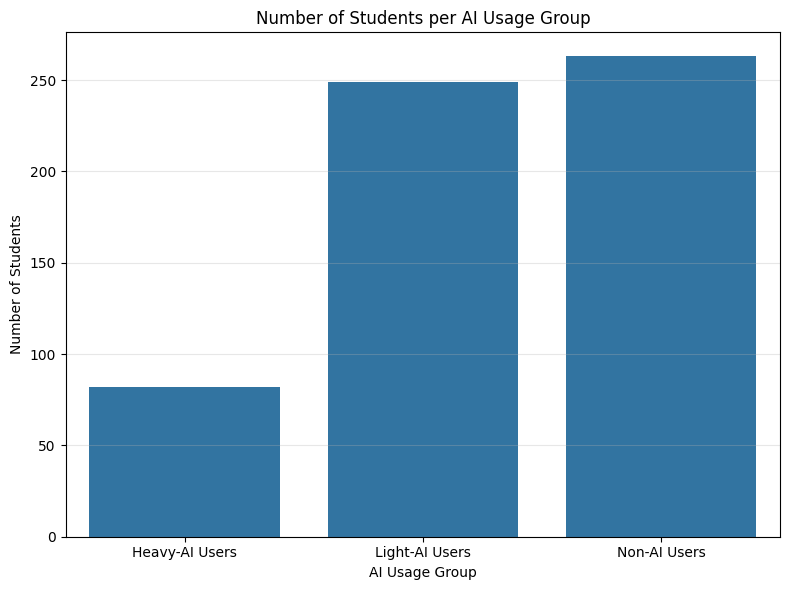

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count unique users in each AI usage category
user_counts = math_data_categorical.groupby('Mathe_ai_usage_category')['user_id'].nunique()

# Optional: Rename index for nicer labels
user_counts.index = user_counts.index.map({
    'non_ai_user': 'Non-AI Users',
    'light_ai_user': 'Light-AI Users',
    'heavy_ai_user': 'Heavy-AI Users'
})

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=user_counts.index, y=user_counts.values)
plt.title('Number of Students per AI Usage Group')
plt.xlabel('AI Usage Group')
plt.ylabel('Number of Students')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


The preprocessing pipeline above is designed to clean, align, and annotate data relative to student learning behavior, AI tutor interactions, and task performance, in preparation for downstream modeling using Knowledge Tracing (KT) approaches — specifically BKT and AFM/PFA. The goal is to enable the analysis of student performance across time and skill domains as a function of AI usage, in order to assess the effectiveness of the Gymitrainer AI model.

The dataset gymitrainer.csv contains logs of AI tutor interactions with users but uses a different identifier format from the user_id used in the rest of the platform’s data. To align these, we used mapping.csv, which provides a timestamp-based mapping with associated confidence scores. We applied a confidence threshold of 0.5 to retain only reliable mappings, and performed an inner join between gymitrainer.csv and the filtered mapping. This ensured that the resulting data only included verified student interactions with the AI tutor.

Each AI interaction is labeled with a tag indicating its subject domain. We standardized these labels by mapping inconsistent entries (e.g, Mathehilfe, essay_writing) to a consistent set: Mathe (math), Aufsatz (essay), Sprache (text comprehension), and Gespräch (voice-based interactions). For interactions with missing tags, we inferred the subject domain by analyzing the AI’s introduction messages and mapping the interaction to the correct subject. This step ensured that each interaction was properly assigned to a subject or excluded from analysis when irrelevant.

To focus exclusively on student learning behavior, we removed all entries where the user_id appeared in teachers.csv. This eliminated any potential interference from teachers experimenting with the platform.

The original math_questions.csv was enriched with a skill_id column to enable KT modeling. Rather than assigning each question_id a unique skill — which would result in sparse and uninformative practice patterns — we grouped similar questions under broader skill categories. Using ChatGPT by giving it math_questions.csv and explaning to it GoGymi platform’s curriculum structure, we classified questions into three high-level skill domains: Zahlen und Arithmetik (direct arithmetic and computation tasks), Textaufgaben (applied word problems involving context or units) and Geometrie (geometry-based tasks). This design balances generalization and fidelity by reducing misclassification risk while preserving topic-level granularity. The resulting dataset is saved as math_questions_clean.csv.

Each entry in math_results.csv was linked to a skill_id using the classification in math_questions_clean.csv. We removed entries with invalid or unclassifiable questions. The resulting math_data dataset includes: skill_id (curriculum-aligned skill label), correct (binary correctness (0/1) directly taken from the original dataset), hint_used (whether a hint was used (derived from hint_count)) and timestamp (time column in the original dataset).

Using the cleaned Gymitrainer interactions, we computed subject-specific AI usage per student: The number of AI messages was counted for each user in each subject (Mathe, Aufsatz, Sprache). A 75th percentile threshold was used to define usage categories: non_ai_user (0 messages), light_ai_user (1 to threshold) and heavy_ai_user (above threshold). This normalization accounts for differing AI usage patterns across subjects. The resulting categories (e.g, Mathe_ai_usage_category) were merged into the subject-specific learning datasets. Missing values (e.g, users who never used the AI) were filled as 0 messages and labeled as non_ai_user.

The math_data was sorted first by user_id and then by timestamp to ensure the temporal ordering of student attempts. This is essential for any sequential modeling approach such as BKT, AFM, or PFA.

We created the following features used in AFM and PFA models: prev_attempts (number of prior attempts by a student on the same skill), before_correct_num (number of successful attempts before the current one), before_wrong_num (number of failed attempts before the current one). These features allow models to estimate how practice and correctness history influence future performance.

The same preprocessing pipeline was scaffolded (and partially implemented) for Essay writing (essay_data_categorical) and Text comprehension (text_data_categorical). While these were commented out in the current code for clarity, they follow the same structure and are ready for full integration. This design ensures scalability of the KT analysis across all subject areas.

The final subject-specific datasets (e.g., math_data_categorical) are now clean, chronologically ordered, and enriched with curriculum-aligned skills, AI usage metadata, and practice history features. These dataframes are now ready for direct input into KT models to assess learning outcomes under different AI usage patterns.

## Task 2: Model Building

Train a model for your research question. 

# BKT

In [23]:
df_non = df_non_ai_math[['user_id', 'order_id', 'skill_id', 'correct']].copy()
df_non = df_non.rename(columns={"skill_id": "skill_name"})

df_light = df_light_ai_math[['user_id', 'order_id', 'skill_id', 'correct']].copy()
df_light = df_light.rename(columns={"skill_id": "skill_name"})

df_heavy = df_heavy_ai_math[['user_id', 'order_id', 'skill_id', 'correct']].copy()
df_heavy = df_heavy.rename(columns={"skill_id": "skill_name"})

In [24]:
def create_iterator(data): ## TODO
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupShuffleSplit(n_splits=1, train_size=.7, test_size=0.3, random_state=0).split(X, groups=groups)

In [25]:
def run_model_on_data(data):
    train_idx, test_idx = next(create_iterator(data))
    train_data = data.iloc[train_idx]
    test_data = data.iloc[test_idx]

    model = Model(seed=0)
    model.fit(data=train_data)

    preds = model.predict(data=test_data)[['user_id', 'skill_name', 'correct', 'correct_predictions']]
    preds.columns = ['user_id', 'skill_name', 'y_true', 'y_pred_bkt']

    return preds

predictions1 = run_model_on_data(df_non)
predictions2 = run_model_on_data(df_light)
predictions3 = run_model_on_data(df_heavy)

display(predictions1)
display(predictions2)
display(predictions3)

,user_id,skill_name,y_true,y_pred_bkt
1187,56,Textaufgaben,1,0.58032
1188,56,Geometrie,0,0.46073
1189,56,Textaufgaben,1,0.63774
1190,56,Textaufgaben,0,0.66472
1191,56,Textaufgaben,0,0.64309
...,...,...,...,...
52603,4067,Textaufgaben,1,0.29724
52604,4067,Textaufgaben,0,0.35242
52605,4067,Textaufgaben,0,0.30546
52606,4067,Zahlen und Arithmetik,0,0.29074


,user_id,skill_name,y_true,y_pred_bkt
738,20,Zahlen und Arithmetik,0,0.60676
739,20,Zahlen und Arithmetik,0,0.54497
740,20,Zahlen und Arithmetik,0,0.51094
741,20,Zahlen und Arithmetik,1,0.49588
742,20,Zahlen und Arithmetik,1,0.50482
...,...,...,...,...
56128,4095,Textaufgaben,0,0.64260
56129,4095,Zahlen und Arithmetik,0,0.49384
56130,4095,Textaufgaben,1,0.58730
56131,4095,Zahlen und Arithmetik,0,0.48907


,user_id,skill_name,y_true,y_pred_bkt
2732,74,Zahlen und Arithmetik,0,0.56231
2733,74,Textaufgaben,0,0.54624
2734,74,Zahlen und Arithmetik,0,0.51487
2735,74,Zahlen und Arithmetik,0,0.48856
2736,74,Zahlen und Arithmetik,0,0.47606
...,...,...,...,...
53978,4074,Zahlen und Arithmetik,0,0.46666
53979,4074,Zahlen und Arithmetik,0,0.46661
53980,4074,Textaufgaben,1,0.80397
53981,4074,Textaufgaben,1,0.80844


In [26]:
def avg_y_by_x(x, y):
    '''
    Compute average learning curve and number of students over the number of opportunities. 
    x is the number of opportunities.
    y the success rates of the users (can be predicted success rate or true success rate).
    '''
    # Transform lists into arrays
    x = np.array(x)
    y = np.array(y)

    # Sort the integer id representing the number of opportunities in increasing order
    xs = sorted(list(set(x)))

    # Supporting lists to store the:
    # - xv: integer identifier of the number of opportunities
    # - yv: average value across students at that number of opportunities
    # - lcb and ucb: lower and upper confidence bound
    # - n_obs: number of observartions present at that number of opportunities (on per-skill plots, it is the #students)
    xv, yv, lcb, ucb, n_obs = [], [], [], [], []

    # For each integer identifier of the number of opportunities 0, ...
    for v in xs:
        ys = [y[i] for i, e in enumerate(x) if e == v] # We retrieve the values for that integer identifier
        if len(ys) > 0: 
            xv.append(v) # Append the integer identifier of the number of opportunities
            yv.append(sum(ys) / len(ys)) # Append the average value across students at that number of opportunities
            n_obs.append(len(ys)) # Append the number of observartions present at that number of opportunities

            
            # Prepare data for confidence interval computation
            unique, counts = np.unique(ys, return_counts=True)
            counts = dict(zip(unique, counts))

            if 0 not in counts:
                counts[0] = 0
            if 1 not in counts:
                counts[1] = 0

            # Calculate the 95% confidence intervals
            ci = sc.stats.beta.interval(0.95, 0.5 + counts[0], 0.5 + counts[1])
            lcb.append(ci[0])
            ucb.append(ci[1])

    return xv, yv, lcb, ucb, n_obs

In [27]:
def plot_learning_curves_for_dataset(predictions, skill_names):
    """
    Plot learning curves for multiple skills from a single dataset.
    Each skill is shown as a column (side-by-side), with 2 rows: 
    top for learning curve, bottom for opportunity histogram.
    """
    n_skills = len(skill_names)
    fig, axs = plt.subplots(2, n_skills, figsize=(6 * n_skills, 5), gridspec_kw={'height_ratios': [3, 2]})

    for idx, skill_name in enumerate(skill_names):
        preds = predictions[predictions['skill_name'] == skill_name]

        xp = []
        yp = {}
        for col in preds.columns:
            if 'y_' in col:
                yp[col] = []

        for user_id in preds['user_id'].unique():
            user_preds = preds[preds['user_id'] == user_id]
            xp += list(np.arange(len(user_preds)))
            for col in preds.columns:
                if 'y_' in col:
                    yp[col] += user_preds[col].tolist()

        lines = []
        for col in preds.columns:
            if 'y_' in col:
                x, y, lcb, ucb, n_obs = avg_y_by_x(xp, yp[col])
                #y = [1-v for v in y] # Transform success rate in error rate
                if col == 'y_true':
                    axs[0, idx].fill_between(x, lcb, ucb, alpha=.1)
                model_line, = axs[0, idx].plot(x, y, label=col)
                lines.append(model_line)

        axs[0, idx].set_title(skill_name)
        axs[0, idx].legend(handles=lines)
        axs[0, idx].set_ylabel('Success')
        axs[0, idx].set_ylim(0, 1)
        axs[0, idx].set_xlim(0, None)

        axs[1, idx].set_xlabel('#Opportunities')
        axs[1, idx].bar([i for i in range(len(n_obs))], n_obs)
        axs[1, idx].set_ylabel('#Observations')
        axs[1, idx].set_ylim(0, 750)
        axs[1, idx].set_xlim(0, None)

    plt.tight_layout()
    plt.show()


=== Non-AI ===


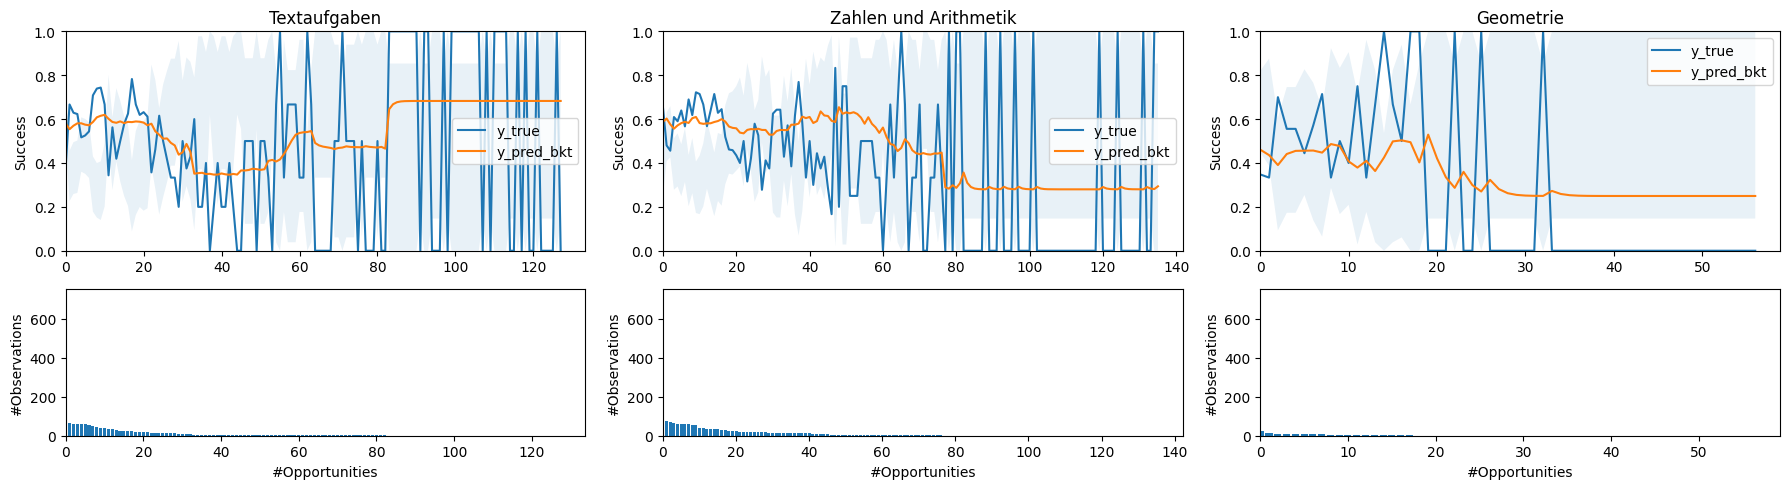

-------------------------------------------------------------------------------------------------------------------------------------------------
=== Light-AI ===


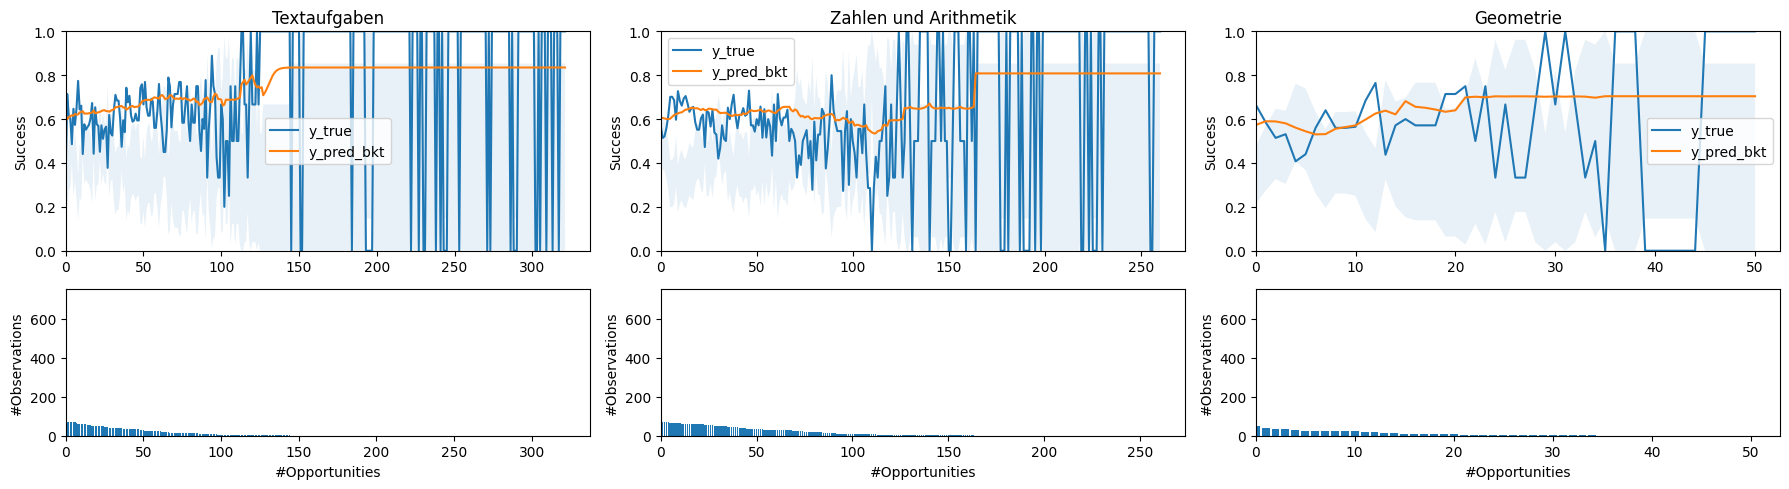

-------------------------------------------------------------------------------------------------------------------------------------------------
=== Heavy-AI ===


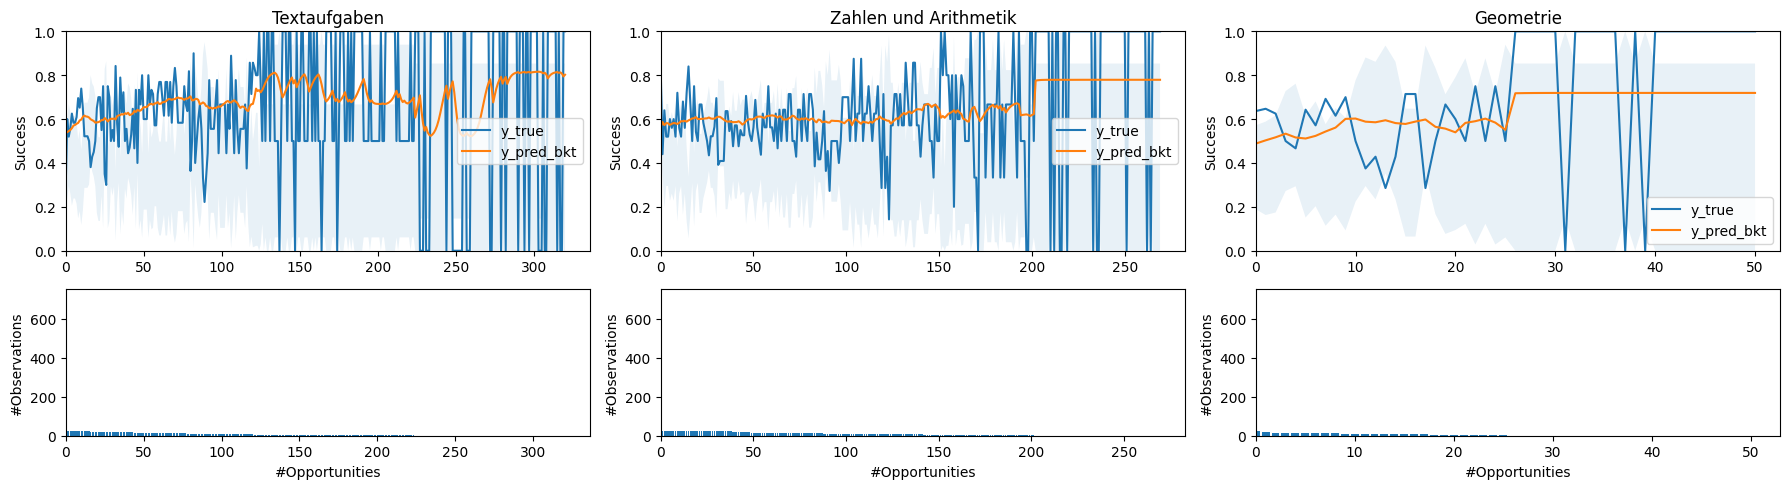

In [28]:
skills_subset = ['Textaufgaben', 'Zahlen und Arithmetik', 'Geometrie']

print("=== Non-AI ===")
plot_learning_curves_for_dataset(predictions1, skills_subset)
print(145* '-')

print("=== Light-AI ===")
plot_learning_curves_for_dataset(predictions2, skills_subset)
print(145* '-')

print("=== Heavy-AI ===")
plot_learning_curves_for_dataset(predictions3, skills_subset)





### BKT
(BKT) is a particularly strong and appropriate choice for modeling student interaction data in intelligent tutoring systems or educational platforms, especially when the goal is to understand how student knowledge evolves over time on specific skills.

We fit a separate model per category of AI usage, which is appropriate because we want to study the effect of the AI chatbot on students, across different skills.
Additionally, each trained model uses cross-validation to reduce overfitting.

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [40]:
def compute_skill_metrics(df_preds, model_col='y_pred_bkt', y_col='y_true'):
    skill_rmse = df_preds.groupby('skill_name').apply(
        lambda df: np.sqrt(mean_squared_error(df[y_col], df[model_col]))
    )

    skill_auc = df_preds.groupby('skill_name').apply(
        lambda df: roc_auc_score(df[y_col], df[model_col]) if len(df[y_col].unique()) > 1 else np.nan
    )

    print(f"RMSE: {skill_rmse}\n mean = {skill_rmse.mean():.4f}, std = {skill_rmse.std():.4f}")
    print(f"AUC: {skill_auc}\n mean = {skill_auc.mean():.4f}, std = {skill_auc.std():.4f}")

    return {
        'RMSE': skill_rmse,
        'AUC': skill_auc
    }

<Figure size 1200x600 with 0 Axes>

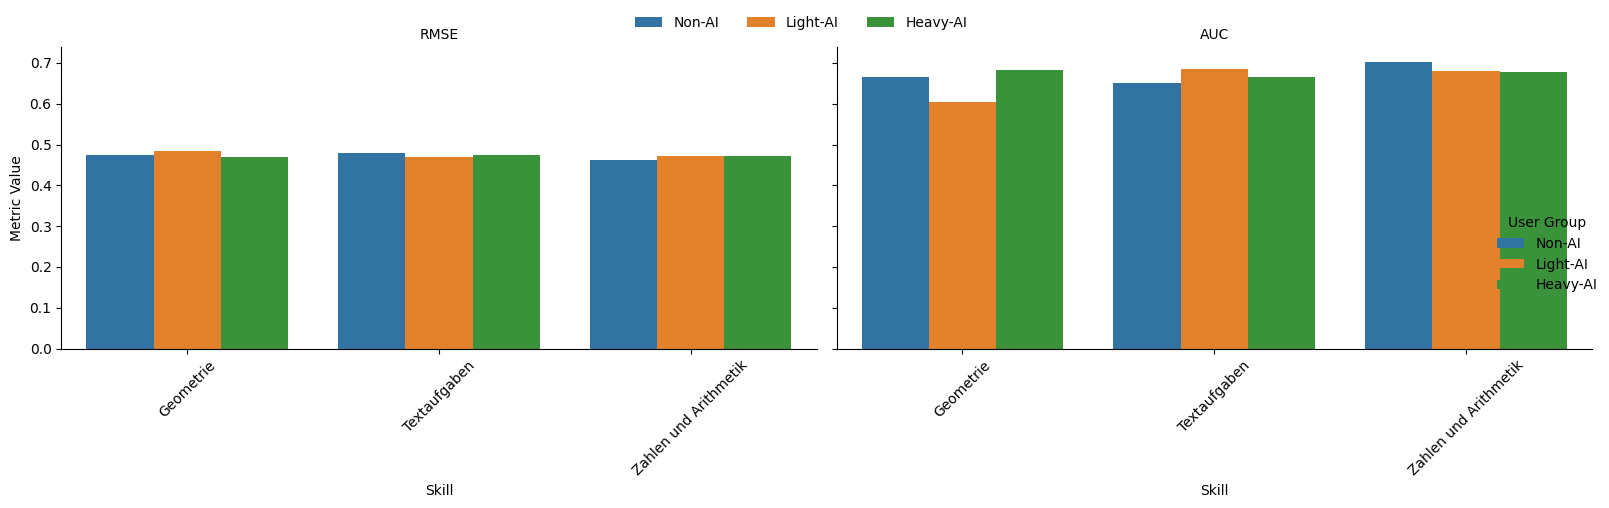

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example input: 3 dicts (from Non-AI, Light-AI, Heavy-AI)
# Assuming these are the same structure as what you shared:
# predictions1, predictions2, predictions3

def prepare_long_df(metrics_dict, group_name):
    df = pd.DataFrame({
        'skill': metrics_dict['RMSE'].index,
        'RMSE': metrics_dict['RMSE'].values,
        'AUC': metrics_dict['AUC'].values,
        'group': group_name
    })
    return df

# Prepare one DataFrame from all groups
df_all = pd.concat([
    prepare_long_df(metrics1, 'Non-AI'),
    prepare_long_df(metrics2, 'Light-AI'),
    prepare_long_df(metrics3, 'Heavy-AI'),
], ignore_index=True)

# Melt into long format for grouped barplot
df_long = df_all.melt(id_vars=['skill', 'group'], value_vars=['RMSE', 'AUC'],
                      var_name='metric', value_name='value')

# Plot
plt.figure(figsize=(12, 6))
g = sns.catplot(
    data=df_long,
    kind='bar',
    x='skill',
    y='value',
    hue='group',
    col='metric',
    height=5,
    aspect=1.5,
)

# Customize titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Skill", "Metric Value")
g.set_xticklabels(rotation=45)

# Move legend above the plots
g._legend.set_title("User Group")
g.fig.subplots_adjust(top=0.85)  # Leave space on top
g.fig.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=len(df_long['group'].unique()),
    frameon=False
)


plt.tight_layout()
plt.show()


### RMSE
The Root Mean Squared Error (RMSE) measures how closely the model’s predicted probabilities align with the actual binary outcomes (correct or incorrect answers). Since BKT outputs probabilities and the ground truth is binary, a lower RMSE (ranging from 0 to 1) indicates better calibration—i.e., the predicted probabilities more accurately reflect the true likelihood of a correct response on average.

### AUC-ROC
The Area Under the ROC Curve (AUC-ROC) evaluates the model’s ability to distinguish between correct and incorrect responses. It answers the question: “If we randomly select one correct and one incorrect case, how likely is the model to assign a higher probability to the correct one?” Values range from 0.5 (no better than random guessing) to 1.0 (perfect discrimination), with higher values indicating better separability between correct and incorrect predictions.

### Result
Based on the BKT results, the AI chatbot does not appear to significantly support student learning in mathematics. Across all skills with sufficient data, the learning curves show minimal variation between AI usage groups, and the evaluation metrics (AUC and RMSE) are nearly identical across these groups. In fact, students who did not use the AI chatbot consistently achieved the best performance, suggesting no measurable benefit from AI assistance in this context.

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

Distribution of work:

Alban: Focused on preprocessing and writing the report

Osman: Focused on BKT and other model exploration as well as writing the report

Filip: Focused on BKT and writing the report

Things to improve would be to spread out our work a bit more, over more weeks, instead of intensely working on it in the last 10 days.